In [167]:
'''
Classification of Motor Imagery EEG signal
2022.5.21 Z.Gan
'''
'''
因为编写时目的是快速验证想法或者调试参数，代码的结构混乱（没时间修了），总体上前面是DataMining+Train，后面是ModelDefinitions
如果希望执行完整的过程，务必首先进行简单的按模块阅读（看前面注释），然后选择需要的模块执行
如果只希望使用EEGNet生成结果，执行前4个模块
2022.6.28 Z.Gan
'''

import numpy as np
import xgboost as xgb
import sklearn
import gc
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
from scipy.linalg import fractional_matrix_power
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader

def EA(X):
    N = X.shape[0]
    R=sum([np.dot(X[i],X[i].T) for i in range(N)])
    R_ = fractional_matrix_power(R/N, -1/2)
    return np.array([np.dot(R_,X[i]) for i in range(N)])

train_path='../input/eegsportimage/train/'
test_path='../input/eegsportimage/test/'
train_x=[]
train_y=[]
test_x=[]
test_y=[]
train_x_hand=[]
train_y_hand=[]
train_x_feet=[]
train_y_feet=[]
test_x_hand=[]
test_x_feet=[]
for i in range(4):
    tmp=np.load(train_path+'S'+str(i+1)+'.npz')
    label=tmp.files #X,y
    train_x.append(tmp[label[0]])
    train_y.append(tmp[label[1]])
    train_x_hand.append(tmp[label[0]][:100])
    train_y_hand.append(tmp[label[1]][:100])
    train_x_feet.append(tmp[label[0]][100:])
    train_y_feet.append(tmp[label[1]][100:])
    tmp=np.load(test_path+'S'+str(i+5)+'.npz')
    test_x.append(tmp[label[0]])
    test_x_hand.append(tmp[label[0]][:100])
    test_x_feet.append(tmp[label[0]][100:])
train_x,train_y=np.vstack(train_x),np.hstack(train_y)
# train_x_hand,train_y_hand=np.vstack(train_x_hand),np.hstack(train_y_hand)
# train_x_feet,train_y_feet=np.vstack(train_x_feet),np.hstack(train_y_feet)
test_x=np.vstack(test_x)
tmp=EA(np.vstack((train_x,test_x)))
EM_train_x=tmp.copy()
train_x,test_x=tmp[:800],tmp[800:]
#print(tmp.shape,test_x.shape);input()
# test_x_hand=np.vstack(test_x_hand)
# test_x_feet=np.vstack(test_x_feet)
train_x.shape,test_x.shape,train_y.shape #((800, 13, 750), (800,))
#shuffle
ind=np.random.permutation(np.arange(len(train_x)))
train_x,train_y=train_x[ind],train_y[ind]
def dis_abs(v1,v2):
    l1,l2=v1.shape
    tmp=0
    for i in range(l1):
        tmp+=sum([abs(v1[i][j]-v2[i][j]) for j in range(l2)])/l2
    return tmp/l1
def search(tx):
    d={}
    x1,x2,x3,x4=np.split(tx,[2,4,6])
    t1,t
    x1,x2,x3,x4=sum(x1)/len(x1),sum(x2)/len(x2),sum(x3)/len(x3),sum(x4)/len(x4)
    r=[]
    for i in range(4):
        dis=[]
        for j in range(4):
            if i==j:continue
            dis.append(dis_abs(eval('x'+str(i+1)),eval('x'+str(j+1))))
        r.append([np.argmin(dis),dis])
        
    return r
#r=search(train_x)
# ind=np.random.permutation(np.arange(len(train_x_hand)))
# train_x_hand,train_y_hand=train_x_hand[ind],train_y_hand[ind]
# ind=np.random.permutation(np.arange(len(train_x_feet)))
# train_x_feet,train_y_feet=train_x_feet[ind],train_y_feet[ind]
del tmp
gc.collect()

128

In [158]:
# used model!!!
import torch
import torch.nn as nn
import torch.nn.functional as F

class eeg_base(nn.Module):
    def __init__(self, classes_num,sp):
        super(eeg_base, self).__init__()
        self.drop_out =0.1
        
        self.block_1 = nn.Sequential(
            # Pads the input tensor boundaries with zero
            # left, right, up, bottom
            nn.ZeroPad2d((31,32, 0, 0)),
            nn.Conv2d(
                in_channels=1,          # input shape (1, C, T)
                out_channels=8,         # num_filters
                kernel_size=(1, 64),    # filter size
                bias=False
            ),                          # output shape (8, C, T)
            nn.BatchNorm2d(8)           # output shape (8, C, T)
        )
        
        # block 2 and 3 are implementations of Depthwise Convolution and Separable Convolution
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,          # input shape (8, C, T)
                out_channels=16,        # num_filters
                kernel_size=(13, 1),    # filter size
                groups=8,
                bias=False
            ),                          # output shape (16, 1, T)
            nn.BatchNorm2d(16),         # output shape (16, 1, T)
            nn.ELU(),
            nn.AvgPool2d((1, 4)),       # output shape (16, 1, T//4)
            nn.Dropout(self.drop_out)   # output shape (16, 1, T//4)
        )
        
        self.block_3 = nn.Sequential(
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
               in_channels=16,          # input shape (16, 1, T//4)
               out_channels=16,         # num_filters
               kernel_size=(1, 16),     # filter size
               groups=16,
               bias=False
            ),                          # output shape (16, 1, T//4)
            nn.Conv2d(
                in_channels=16,         # input shape (16, 1, T//4)
                out_channels=16,        # num_filters
                kernel_size=(1, 1),     # filter size
                bias=False
            ),                          # output shape (16, 1, T//4)
            nn.BatchNorm2d(16),         # output shape (16, 1, T//4)
            nn.ELU(),
            nn.AvgPool2d((1, 8)),       # output shape (16, 1, T//32)
            nn.Dropout(self.drop_out)
        )
        
        self.out = nn.Linear(sp, classes_num)
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return F.softmax(x, dim=1), x   # return x for visualization
def L2Loss(model,alpha):
    l2_loss = torch.tensor(0.0,requires_grad = True)
    for name,parma in model.named_parameters():
        if 'bias' not in name:
            l2_loss = l2_loss + (0.5*alpha* torch.sum(torch.pow(parma,2)))
    return l2_loss
def DFT(x):
    res=[]
    for i in range(len(x)):
        tmp=[]
        for c in x[i]:
            tmp.append(fft(c)[:len(c)//2][:120])
            #tmp.append(abs(fft(c)[:len(c)//2][120:]))
        #print(len(tmp),tmp[0].shape);input()
        res.append(tmp)
    return np.array(res)

In [159]:
# K fold
def mah(x1,y1,x2,y2):
    x1=np.array([np.ravel(ele) for ele in x1])
    x2=np.array([np.ravel(ele) for ele in x2])
    x1_c0,x1_c1,x2_c0,x2_c1=x1[y1==0],x1[y1==1],x2[y2==0],x2[y2==1]
    def cal_dis(m1,m2):
        m1,m2=sum(m1)/len(m1),sum(m2)/len(m2)
        al=np.vstack((m1,m2))
        D = np.cov(al.T)+0.01  # covariance
        invD = np.linalg.inv(D)  # covariance inverse
        tp=m1-m2
        return np.sqrt(np.dot(np.dot(tp,invD),tp.T))
    return (cal_dis(x1_c0,x2_c0)+cal_dis(x1_c1,x2_c1))/2
# K-fold cross-validation
def kvld(k,FREQ):
    train_path='../input/eegsportimage/train/'
    d=dict()
    for i in range(k):
        tx,ty=[],[]
        for j in range(k):
            if j==i:continue
            else:
                tmp=np.load(train_path+'S'+str(j+1)+'.npz')
                label=tmp.files #X,y
                if FREQ:tx.append(abs(DFT(tmp[label[0]])))
                else:tx.append(tmp[label[0]])
                ty.append(tmp[label[1]])
        tx,ty=EA(np.vstack(tx)),np.hstack(ty)
        d['train'+str(i)]=(tx,ty)
        tmp=np.load(train_path+'S'+str(i+1)+'.npz')
        if FREQ:d['test'+str(i)]=(EA(abs(DFT(tmp[label[0]]))),tmp[label[1]])
        else:d['test'+str(i)]=(EA(tmp[label[0]]),tmp[label[1]])
    return d
def kvld(k):
    train_path='../input/eegsportimage/train/'
    d=dict()
    for i in range(k):
        tx,ty=[],[]
        for j in range(k):
            if j==i:continue
            else:
                tmp=np.load(train_path+'S'+str(j+1)+'.npz')
                label=tmp.files #X,y
                if FREQ:tx.append(abs(DFT(tmp[label[0]])))
                else:tx.append(tmp[label[0]])
                ty.append(tmp[label[1]])
        tmp=np.load(train_path+'S'+str(i+1)+'.npz')
        tx,ty=EA(np.vstack((np.vstack(tx),tmp[label[0]]))),np.hstack(ty)
        d['test'+str(i)]=(tx[-200:],tmp[label[1]])
        d['train'+str(i)]=(tx[:-200],ty)
    return d
#data=kvld(4)
#data['train3'][0].shape

In [168]:
# EEGNet -no K validation
gen=1
EM=0
if EM:
    EM_train_x.shape
    EM_train_y=np.hstack((train_y,p))
    EM_train_y.shape
X,Y=EA(train_x.copy()),train_y.copy()
if not gen:
    train_x,test_x=X[:720],X[720:]
    train_y,test_y=Y[:720],Y[720:]
if EM:
    train_x=EM_train_x
    train_y=EM_train_y
# tx,lx=torch.LongTensor(Tx),torch.LongTensor(Lx)
# ty,ly=torch.LongTensor(train_y),torch.LongTensor(test_y)
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_func = nn.CrossEntropyLoss().to(DEVICE)
#         m=EEGNet(inp_dim=[13,750],chns=[8,16,16],
#                  groups=[8,16],classes_num=2,
#                  pooling=[4,8],dp=0.25,k_size=64).to(DEVICE)
m=eeg_base(2,368).to(DEVICE)
optimizer =optim.Adam(m.parameters())
tx,ty=torch.Tensor(train_x).unsqueeze(1),torch.LongTensor(train_y)
if not gen:vx,vy=torch.Tensor(test_x).unsqueeze(1),torch.LongTensor(test_y)
else:vx=torch.Tensor(test_x).unsqueeze(1)
#print(tx.shape,vx.shape);print(ty.shape,vy.shape)
loader=DataLoader(
    dataset=TensorDataset(tx,ty),
    batch_size=16,
    shuffle=True,
    num_workers=2)
L,A=[],[]
for epoch in range(25):
    for step, (b_x, b_y) in enumerate(loader):
        #print(b_x.shape,b_y.shape);input()
        b_x, b_y = b_x.to(DEVICE), b_y.to(DEVICE)
        output =m(b_x)[0]
        loss = loss_func(output, b_y)+L2Loss(m,0.1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #print((pred_y==vy.data.numpy()).sum())
    if not gen:
        test_out, last_layer=m(vx.to(DEVICE))
        pred_y = torch.max(test_out.cpu(), 1)[1].data.numpy()
        accuracy = float((pred_y ==vy.data.numpy()).astype(int).sum()) / float(vy.size(0))
        L.append(loss.item());A.append(accuracy)
    else:
        test_out, last_layer=m(tx.to(DEVICE))
        pred_y = torch.max(test_out.cpu(), 1)[1].data.numpy()
        accuracy = float((pred_y ==ty.data.numpy()).astype(int).sum()) / float(vy.size(0))
            #print(accuracy)
    #print(str(i)+'Epoch: ', epoch, '| train loss: %.4f' % loss.cpu().data.numpy(), '| test accuracy: %.3f' % accuracy)
if not gen:
    pred,_=m(tx.to(DEVICE))
    p=torch.max(pred.cpu(), 1)[1].data.numpy()
    print((ty.cpu().numpy()==p).sum()/600)
    plt.plot(A)
    print(sum(A)/len(A))
elif gen:
    pred,_=m(tx.to(DEVICE))
    p=torch.max(pred.cpu(), 1)[1].data.numpy()
    #tmp=
    tmp=open("./res.csv","w+")
    tmp.write('s5,s6,s7,s8\n')
    for i in range(200):
        l=str(p[i])+','+str(p[200+i])+','+str(p[400+i])+','+str(p[600+i])+'\n'
        tmp.write(l) 
    tmp.close()
    print((p==1).sum())

339


0.655875
0.6375833333333332
0.6612916666666672
0.6539166666666673
0.6545416666666667
0.655208333333333
0.6610416666666671
0.654375
0.6624583333333334
0.6576666666666663


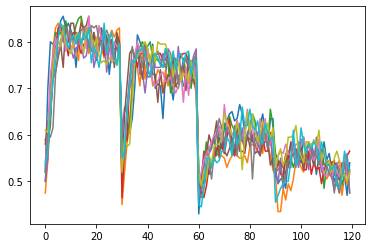

In [91]:
# EEG
for c in range(1):
    LL,AA=[],[]
    for i in range(4):
        train_x,train_y=data['train'+str(i)][0],data['train'+str(i)][1]
        test_x,test_y=data['test'+str(i)][0],data['test'+str(i)][1]
        # tx,lx=torch.LongTensor(Tx),torch.LongTensor(Lx)
        # ty,ly=torch.LongTensor(train_y),torch.LongTensor(test_y)
        DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
        loss_func = nn.CrossEntropyLoss().to(DEVICE)
#         m=EEGNet(inp_dim=[13,750],chns=[8,16,16],
#                  groups=[8,16],classes_num=2,
#                  pooling=[4,8],dp=0.25,k_size=64).to(DEVICE)
#368
        m=eeg_base(2,368).to(DEVICE)
        optimizer =optim.Adam(m.parameters())
        tx,ty=torch.Tensor(train_x).unsqueeze(1),torch.LongTensor(train_y)
        vx,vy=torch.Tensor(test_x).unsqueeze(1),torch.LongTensor(test_y)
        #print(tx.shape,vx.shape);print(ty.shape,vy.shape)
        loader=DataLoader(
            dataset=TensorDataset(tx,ty),
            batch_size=16,
            shuffle=True,
            num_workers=2)
        L,A=[],[]
        for epoch in range(30):
            for step, (b_x, b_y) in enumerate(loader):
                #print(b_x.shape,b_y.shape);input()
                b_x, b_y = b_x.to(DEVICE), b_y.to(DEVICE)
                output =m(b_x)[0]
                loss = loss_func(output, b_y)+L2Loss(m,0.1)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            test_out, last_layer=m(vx.to(DEVICE))
            pred_y = torch.max(test_out.cpu(), 1)[1].data.numpy()
            #print((pred_y==vy.data.numpy()).sum())
            accuracy = float((pred_y ==vy.data.numpy()).astype(int).sum()) / float(vy.size(0))
            L.append(loss.item());A.append(accuracy)
            #print(str(i)+'Epoch: ', epoch, '| train loss: %.4f' % loss.cpu().data.numpy(), '| test accuracy: %.3f' % accuracy)
        pred,_=m(tx.to(DEVICE))
        p=torch.max(pred.cpu(), 1)[1].data.numpy()
        #print((ty.cpu().numpy()==p).sum()/600)
        LL.extend(L)
        AA.extend(A)
    plt.plot(AA)
    #print('loss:',sum(LL)/len(LL))
    print(sum(AA)/len(AA))
    #print(sum(AA[:c])/c,';',sum(AA[c:c*2])/c,';',sum(AA[c*2:c*3])/c,';',sum(AA[c*3:])/c)
# plt.plot(L,A)
# plt.clf()

In [ ]:
# Transformer
#train_x=np.round(train_x).astype('int32')
#tx,ty=torch.LongTensor(train_x).to(device).flatten(1),torch.LongTensor(train_y).to(device)
vy,ty=torch.LongTensor(vy).unsqueeze(1),torch.LongTensor(ty).unsqueeze(1)
tx,vx=tx-tx.min(),vx-vx.min()
dic_len_enc=max(tx.max().item(),vx.max().item())
dic_len_dec=2+1 # 2 categories
bs=12
sten_len=tx.shape[-1] # source sentences length
tar_len=1 # target sentences length
print(tx.shape,vx.shape,ty.shape,vy.shape)
m=transformer(dic_len_enc+1,dic_len_dec,0,0,
              d_word_vec=16, d_model=16, d_inner=128,
              n_head=4,d_k=16, d_v=16,n_position=len(tx[0]))
data=TensorDataset(tx,ty)
loader=DataLoader(
    dataset=data,
    batch_size=bs,
    shuffle=True,
    num_workers=2)
loader_test=DataLoader(
    dataset=TensorDataset(vx,vy),
    batch_size=bs,
    shuffle=True,
    num_workers=2)
L=[]
for i in range(10):
    L.append(train_epoch(m,loader))
ac,res=test(m,loader) #1
print(L,ac)

In [50]:
# model definition(EEGnet)
import torch
import torch.nn as nn
import torch.nn.functional as F


class EEGNet(nn.Module):
    def __init__(self,inp_dim=[13,750],chns=[12,24,24],
                 groups=[6,12],classes_num=2,
                 pooling=[6,6],dp=0.1,k_size=64
                 ):
        super(EEGNet, self).__init__()
        self.drop_out =dp
        
        self.block_1 = nn.Sequential(
            # nn.ZeroPad2d((left, right, up, bottom))
            # fill '0' in excepted directions
            #nn.ZeroPad2d((0,0, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=chns[0],
                kernel_size=(1,k_size),
                bias=False
            ),
            nn.BatchNorm2d(chns[0])
        )
        # block 2 and 3 are implementations of Depthwise Convolution and Separable Convolution
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=chns[0],
                out_channels=chns[1],
                kernel_size=(inp_dim[0], 1),
                groups=groups[0],
                bias=False
            ),
            nn.BatchNorm2d(chns[1]),
            nn.ELU(),
            nn.AvgPool2d((1,pooling[0])),
            nn.Dropout(self.drop_out)
        )
        
        self.block_3 = nn.Sequential(
            #nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
               in_channels=chns[1],
               out_channels=chns[1],
               kernel_size=(1,1),
               groups=groups[1],
               bias=False
            ), # (chns[2], 1, T//4)
            nn.Conv2d(
                in_channels=chns[1],
                out_channels=chns[2],
                kernel_size=(1, 1),
                bias=False
            ), # (16, 1, T//4)
            nn.BatchNorm2d(chns[2]),
            nn.ELU(),
            nn.AvgPool2d((1,pooling[1])), # (chns[2], 1, T//32)
            nn.Dropout(self.drop_out)
        )
        dim=chns[2]*((inp_dim[1]-k_size+1)//pooling[0]//pooling[1])
        self.out1 = nn.Linear(dim,dim//2)
        self.out2 = nn.Linear(dim//2,classes_num)
    
    def forward(self, x):
        x = self.block_1(x)
        #print(x.shape) # [1,chn[0],inp_dim[0],inp_dim[1]-k_size+1]
        x = self.block_2(x)
        #print(x.shape) # [1,chn[1], 1,~//pooling[0]]
        x = self.block_3(x)
        #print(x.shape);input() # [1,chn[1], 1,~//pooling[1]]
        
        x = x.view(x.size(0), -1)
        x = self.out2(self.out1(x))
        return F.softmax(x, dim=1), x   # return x for visualization

In [7]:
# transformer definition
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        #print(q.size(0), q.size(1), k.size(1), v.size(1))
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)
        #print(q.size(0), q.size(1), k.size(1), v.size(1))

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn

class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn

class DecoderLayer(nn.Module):
    ''' Compose with three layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        return dec_output, dec_slf_attn, dec_enc_attn

def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)

def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask

class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()

        # Not a parameter
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):
        ''' Sinusoid position encoding table '''
        # TODO: make it with torch instead of numpy

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()

class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []

        # -- Forward
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []

        if return_attns:
            return enc_output, enc_slf_attn_list
        return enc_output,

class Decoder(nn.Module):
    ''' A decoder model with self attention mechanism. '''

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []

        # -- Forward
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []

        if return_attns:
            return dec_output, dec_slf_attn_list, dec_enc_attn_list
        return dec_output,

class transformer(nn.Module):
    '''
    A sequence to sequence model with attention mechanism.
    n_src_vocab and n_trg_vocab are input and output dictionary lengths
    if the input shape is [(1,w)(1,y)], the output shape is (y,n_trg_vocab)
    '''
    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=64, d_model=64, d_inner=128,
            n_layers=1, n_head=1, d_k=64, d_v=64, dropout=0.1, n_position=750,
            trg_emb_prj_weight_sharing=False, emb_src_trg_weight_sharing=False,
            scale_emb_or_prj='none'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        # In section 3.4 of paper "Attention Is All You Need", there is such detail:
        # "In our model, we share the same weight matrix between the two
        # embedding layers and the pre-softmax linear transformation...
        # In the embedding layers, we multiply those weights by \sqrt{d_model}".
        #
        # Options here:
        #   'emb': multiply \sqrt{d_model} to embedding output
        #   'prj': multiply (\sqrt{d_model} ^ -1) to linear projection output
        #   'none': no multiplication

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            # Share the weight between target word embedding & last dense layer
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)
        #print()
        enc_output, *_ = self.encoder(src_seq, src_mask)
        #print(enc_output);print()
        dec_output, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2))

class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

class Translator(nn.Module):
    ''' Load a trained model and translate in beam search fashion. '''

    def __init__(
            self, model, beam_size, max_seq_len,
            src_pad_idx, trg_pad_idx, trg_bos_idx, trg_eos_idx):
        

        super(Translator, self).__init__()

        self.alpha = 0.7
        self.beam_size = beam_size
        self.max_seq_len = max_seq_len
        self.src_pad_idx = src_pad_idx
        self.trg_bos_idx = trg_bos_idx
        self.trg_eos_idx = trg_eos_idx

        self.model = model
        self.model.eval()

        self.register_buffer('init_seq', torch.LongTensor([[trg_bos_idx]]))
        self.register_buffer(
            'blank_seqs', 
            torch.full((beam_size, max_seq_len), trg_pad_idx, dtype=torch.long))
        self.blank_seqs[:, 0] = self.trg_bos_idx
        self.register_buffer(
            'len_map', 
            torch.arange(1, max_seq_len + 1, dtype=torch.long).unsqueeze(0))


    def _model_decode(self, trg_seq, enc_output, src_mask):
        trg_mask = get_subsequent_mask(trg_seq)
        dec_output, *_ = self.model.decoder(trg_seq, trg_mask, enc_output, src_mask)
        return F.softmax(self.model.trg_word_prj(dec_output), dim=-1)


    def _get_init_state(self, src_seq, src_mask):
        beam_size = self.beam_size

        enc_output, *_ = self.model.encoder(src_seq, src_mask)
        dec_output = self._model_decode(self.init_seq, enc_output, src_mask)
        
        best_k_probs, best_k_idx = dec_output[:, -1, :].topk(beam_size)

        scores = torch.log(best_k_probs).view(beam_size)
        gen_seq = self.blank_seqs.clone().detach()
        gen_seq[:, 1] = best_k_idx[0]
        enc_output = enc_output.repeat(beam_size, 1, 1)
        return enc_output, gen_seq, scores


    def _get_the_best_score_and_idx(self, gen_seq, dec_output, scores, step):
        assert len(scores.size()) == 1
        
        beam_size = self.beam_size

        # Get k candidates for each beam, k^2 candidates in total.
        best_k2_probs, best_k2_idx = dec_output[:, -1, :].topk(beam_size)

        # Include the previous scores.
        scores = torch.log(best_k2_probs).view(beam_size, -1) + scores.view(beam_size, 1)

        # Get the best k candidates from k^2 candidates.
        scores, best_k_idx_in_k2 = scores.view(-1).topk(beam_size)
 
        # Get the corresponding positions of the best k candidiates.
        best_k_r_idxs, best_k_c_idxs = best_k_idx_in_k2 // beam_size, best_k_idx_in_k2 % beam_size
        best_k_idx = best_k2_idx[best_k_r_idxs, best_k_c_idxs]

        # Copy the corresponding previous tokens.
        gen_seq[:, :step] = gen_seq[best_k_r_idxs, :step]
        # Set the best tokens in this beam search step
        gen_seq[:, step] = best_k_idx

        return gen_seq, scores


    def translate_sentence(self, src_seq):
        # Only accept batch size equals to 1 in this function.
        # TODO: expand to batch operation.
        assert src_seq.size(0) == 1

        src_pad_idx, trg_eos_idx = self.src_pad_idx, self.trg_eos_idx 
        max_seq_len, beam_size, alpha = self.max_seq_len, self.beam_size, self.alpha 

        with torch.no_grad():
            src_mask = get_pad_mask(src_seq, src_pad_idx)
            enc_output, gen_seq, scores = self._get_init_state(src_seq, src_mask)

            ans_idx = 0   # default
            for step in range(2, max_seq_len):    # decode up to max length
                dec_output = self._model_decode(gen_seq[:, :step], enc_output, src_mask)
                gen_seq, scores = self._get_the_best_score_and_idx(gen_seq, dec_output, scores, step)

                # Check if all path finished
                # -- locate the eos in the generated sequences
                eos_locs = gen_seq == trg_eos_idx   
                # -- replace the eos with its position for the length penalty use
                seq_lens, _ = self.len_map.masked_fill(~eos_locs, max_seq_len).min(1)
                # -- check if all beams contain eos
                if (eos_locs.sum(1) > 0).sum(0).item() == beam_size:
                    # TODO: Try different terminate conditions.
                    _, ans_idx = scores.div(seq_lens.float() ** alpha).max(0)
                    ans_idx = ans_idx.item()
                    break
        return gen_seq[ans_idx][:seq_lens[ans_idx]].tolist()

def train_epoch(model,dataloader):
    ''' Epoch operation in training phase'''
    total_loss=0
    optimizer=optim.Adam(model.parameters())
    loss_fuc=nn.CrossEntropyLoss()
    for loc,(x,y) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        # forward
        pred=model(x,torch.tensor(torch.zeros(y.shape),dtype=torch.long)+2)
        # backward and update parameters
        y=y.squeeze(1)
        loss=loss_fuc(pred,y)
        loss.backward()
        optimizer.step()
        # note keeping
        total_loss += loss.item()
    return total_loss

def test(model,data):
    c=0
    l=0
    with torch.no_grad():
        for loc,(x,y) in tqdm(enumerate(data)):
            # forward
            pred=model(x,torch.tensor(torch.zeros(y.shape),dtype=torch.long)+2)
            #print((torch.argmax(pred,1)==y.T).sum());input()
            #print(pred,y)
            l+=pred.shape[0]
            c+=(torch.argmax(pred,1)==y.T).sum().item()
            #print(c)
    return c/l,torch.argmax(pred,1)

In [14]:
# data mining/PCA/split
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
tx=np.transpose(np.round(train_x).astype('int64'),(0,2,1))
lx=np.transpose(np.round(test_x).astype('int64'),(0,2,1))
Lx,Tx=[],[]
for i in range(len(tx)):
    pca.fit(tx[i])
    Tx.append(pca.transform(tx[i]).flatten())
    pca.fit(lx[i])
    Lx.append(pca.transform(lx[i]).flatten())
#split
div=len(train_x)*9//10
tx,vx=np.split(Tx,[div])
ty,vy=np.split(train_y,[div])
tx,vx,lx=torch.LongTensor(tx),torch.LongTensor(vx),torch.LongTensor(Lx)
del Tx,Lx
gc.collect()

699

In [ ]:
#xgboost
div=len(train_x)*9//10
tx,vx=np.split(train_x,[div])
ty,vy=np.split(train_y,[div])
tx,vx=abs(DFT(tx)),abs(DFT(vx))
tx,vx=np.array([np.ravel(tx[i])+i*0.5 for i in range(len(tx))]),np.array([np.ravel(vx[i])+i*0.5 for i in range(len(vx))])
train_x,train_y,test_x,test_y=tx,ty,vx,xy
for i in range(4):
    train_x,train_y=data['train'+str(i)][0],data['train'+str(i)][1]
    test_x,test_y=data['test'+str(i)][0],data['test'+str(i)][1]
    params = {
        "max_depth":7,
        "booster":'gbtree',
        "n_estimators":300,
        "learning_rate":0.003,
        'lambda':3,
        'gamma':0.2,
        'objective': 'binary:logistic',
        "seed":1000
    }
    div=len(train_x)*9//10
#     tx,ty=np.array([np.ravel(ele) for ele in train_x]),train_y
#     test_x=np.array([np.ravel(test_x[i]) for i in range(len(test_x))])
    test_x=np.array([np.ravel(test_x[i])+i*0.5 for i in range(len(test_x))])
    tx,ty=np.array([np.ravel(train_x[i])+i*0.5 for i in range(len(train_x))]),train_y #position encoding
    #print(tx,ty)
#     y=train_y[:div]
#     xt=x[div:]
#     x=x[:div]
#     yt=train_y[div:]
    xgboost=xgb.XGBClassifier(**params)
    xgboost.fit(tx,ty)
    # r=xgboost.predict(x)
    # ac=sum(r==y)/len(y)
    # print(ac) #1.0
    r=xgboost.predict(test_x)
    ac=sum(r==test_y)/len(test_y)
    print(ac)
    r=xgboost.predict(vx)
    ac=sum(r==vy)/len(vy)
    print(ac)
# div=len(train_x_hand)*9//10
# hx,thx=np.split(train_x_hand,[div])
# fx,tfx=np.split(train_x_feet,[div])
# hy,thy=np.split(train_y_hand,[div])
# fy,tfy=np.split(train_y_feet,[div])
# mfeet=xgb.XGBClassifier(**params)
# mhand=xgb.XGBClassifier(**params)
# hx,fx=np.array([np.ravel(ele) for ele in hx]),np.array([np.ravel(ele) for ele in fx])
# thx,tfx=np.array([np.ravel(ele) for ele in thx]),np.array([np.ravel(ele) for ele in tfx])
# mhand.fit(hx,hy)
# mfeet.fit(fx,fy)
# tmp=mhand.predict(thx)
# ac=sum(tmp==thy)/len(thy)
# print(ac)
# tmp=mhand.predict(tfx)
# ac=sum(tmp==tfy)/len(tfy)
# print(ac)
# plot.pyplot.scatter(np.arange(len(train_x[0][0])),train_x[0][0])
# plot.pyplot.plot(train_x[0][1])
# plot.pyplot.plot(train_x[0][0])
# l1=[]
# l2=[]
# for i in range(750):
#     if abs(train_x[0][0][i]-train_x[1][0][i])>3:
#         l1.append([i,train_x[0][0][i]])
#         l2.append([i,train_x[1][0][i]])

In [ ]:
#CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Resblock(nn.Module):
    def __init__(self,inp,outp,stride=1):
        super(Resblock, self).__init__()
        self.conv1 = nn.Conv2d(inp,outp, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(outp,outp, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(inp,outp, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(outp)
        self.bn2 = nn.BatchNorm2d(outp)
        return
    def forward(self,x):
        y=F.relu(self.bn1(self.conv1(x)))
        y=self.bn2(self.conv2(y))
        return F.relu(y+self.conv3(x))

# 2 classes
class CNN(nn.Module):
    def __init__(self,inp,cla):
        super(CNN,self).__init__()
        self.size=inp[0]*inp[1]
        self.episodes=10
        self.loss=nn.CrossEntropyLoss()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.size,750, bias=True),
            nn.GELU(),
            nn.Linear(750,100, bias=True),
            nn.GELU(),
            nn.Linear(100, cla, bias=True)
        )
    def forward(self, x):
        x = self.conv(x)
        x= self.fc(x)
        return F.softmax(x)
    def train(self,x,y):
        losses=[]
        for i in range(self.episodes):
            L=0
            for X,Y in zip(x,y):
                self.optimizer.zero_grad()
                l = self.loss(self.forward(x), Y)
                l.backward()
                self.optimizer.step()
                L+=l.item()
            losses.append(L)
        return losses

m_hand=CNN((13,750),2)
m_feet=CNN((13,750),2)


In [ ]:
#plot
def eeg_plot(sig,domain):
    for i in range(len(sig)):
        ax=plt.subplot(13,1,13-i)
        ax.yaxis.set_major_locator(MultipleLocator(600))
        plt.plot(sig[i],color='blue', linewidth=1.5)
        plt.ylabel('c'+str(i+1))
        if i!=0:plt.xticks([])
        plt.yticks([])
        plt.xlim(0,len(sig[0]))
        if i==0:plt.xlabel(domain)
    plt.gcf().savefig('1.eps',format='eps')
    return